In [1]:
from tectosaur2.nb_config import setup

setup()

In [2]:
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt
from tectosaur2 import gauss_rule, refine_surfaces, integrate_term, tensor_dot
from tectosaur2.laplace2d import double_layer, hypersingular
from tectosaur2.mesh import panelize_symbolic_surface
from tectosaur2.debug import plot_centers

/Users/tbent/Dropbox/active/eq/tectosaur2/tectosaur2/integrate.py:174: UserWarning: Some integrals failed to converge during adaptive integration. This an indication of a problem in either the integration or the problem formulation.
  warnings.warn(
/Users/tbent/Dropbox/active/eq/tectosaur2/tectosaur2/integrate.py:180: UserWarning: Some expanded integrals reached maximum expansion order. These integrals may be inaccurate.
  warnings.warn(


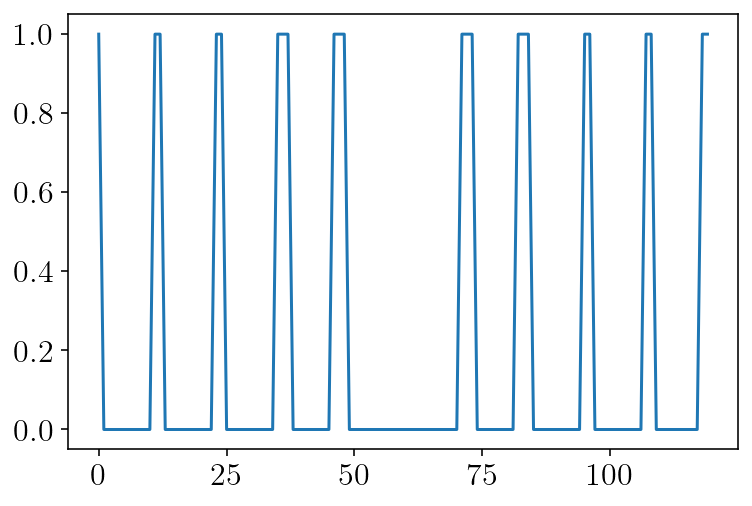

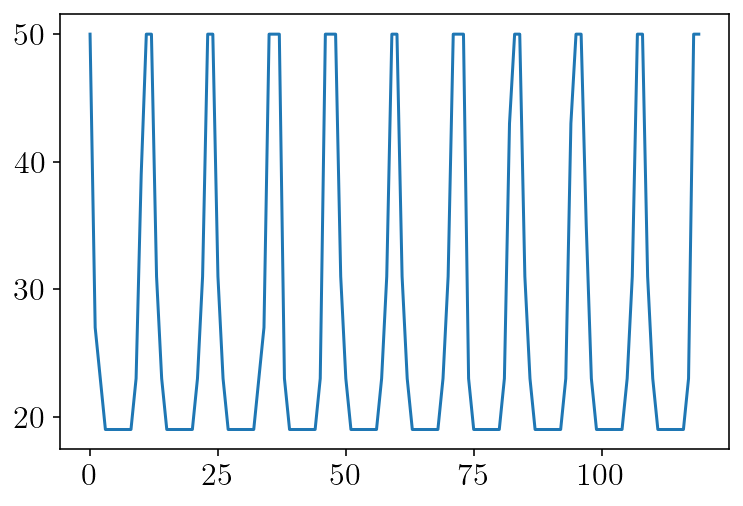

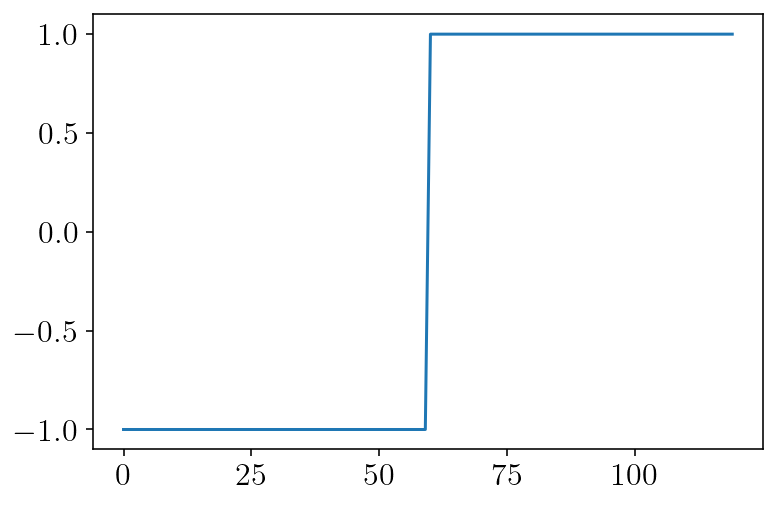

AssertionError: 
Not equal to tolerance rtol=1e-07, atol=0

Mismatched elements: 120 / 120 (100%)
Max absolute difference: 1.
Max relative difference: 2.
 x: array([-0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5,
       -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5,
       -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5,...
 y: array([ 0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  0.5,
        0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  0.5,
        0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  0.5,...

In [3]:
t = sp.var("t")
surf = refine_surfaces(
    [(t, t, 0 * t)], gauss_rule(12), control_points=[(0, 0, 0, 0.2)]
)
displacement = 1 - np.abs(surf.pts[:, 0])
from tectosaur2.laplace2d import Hypersingular
mat,report = integrate_term(
    Hypersingular(max_p=50),
    surf.pts,
    surf,
    tol=1e-11,
    safety_mode=True,
    singularities=[(-1, 0), (1, 0)],
    return_report=True
)
stress = tensor_dot(mat, displacement)
import matplotlib.pyplot as plt
# plt.figure(figsize=(8, 4))
# plt.subplot(1, 2, 1)
# plt.plot(surf.pts[:, 0], displacement)
# plt.subplot(1, 2, 2)
# plt.plot(surf.pts[:, 0], stress[:, 0])
# plt.plot(surf.pts[:, 0], stress[:, 1])
# plt.show()

plt.plot(report['integration_failed'])
plt.show()
plt.plot(report['p'])
plt.show()
plt.plot(stress[:,0]+np.sign(surf.pts[:,0]) * 0.5)
plt.show()
np.testing.assert_allclose(stress[:,0], -np.sign(surf.pts[:,0]) * 0.5)

In [4]:
surf_half_L = 100000
fault_bottom = 40000
max_panel_length = 2000
n_fault=40
shear_modulus = 3.2e10

qx, qw = gauss_rule(7)
t = sp.var("t")

# The number of fault panels should be a multiple of 40.
# so that the kinks in the "a" parameter profile occur at panel boundaries.
edges = np.linspace(-1, 1, n_fault+1)
panel_bounds = np.stack((edges[:-1],edges[1:]), axis=1)
fault = panelize_symbolic_surface(
    t, t * 0, fault_bottom * (t + 1) * -0.5,
    panel_bounds,
    qx, qw
)

print(
    f"The fault mesh has {fault.n_panels} panels with a total of {fault.n_pts} points."
)

The fault mesh has 40 panels with a total of 280 points.


In [14]:
%%time
safe_slip_to_stress, safe_report = integrate_term(
    hypersingular,
    fault.pts,
    fault,
    tol=1e-14,
    safety_mode=True,
    return_report=True,
)

CPU times: user 887 ms, sys: 30.5 ms, total: 918 ms
Wall time: 114 ms


/Users/tbent/Dropbox/active/eq/tectosaur2/tectosaur2/integrate.py:174: UserWarning: Some integrals failed to converge during adaptive integration. This an indication of a problem in either the integration or the problem formulation.
  warnings.warn(
/Users/tbent/Dropbox/active/eq/tectosaur2/tectosaur2/integrate.py:180: UserWarning: Some expanded integrals reached maximum expansion order. These integrals may be inaccurate.
  warnings.warn(


In [15]:

%%time
unsafe_slip_to_stress, unsafe_report = integrate_term(
    hypersingular,
    fault.pts,
    fault,
    tol=1e-14,
    safety_mode=False,
    return_report=True,
)

CPU times: user 140 ms, sys: 13.9 ms, total: 154 ms
Wall time: 26.9 ms


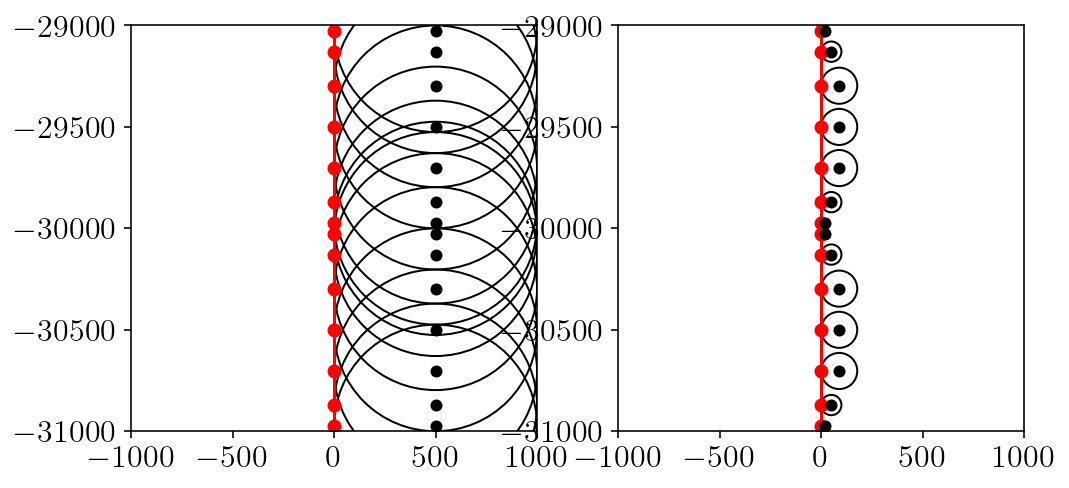

In [16]:
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plot_centers(unsafe_report,[-1000,1000], [-31000, -29000])
plt.subplot(1,2,2)
plot_centers(safe_report,[-1000,1000], [-31000, -29000])
plt.show()

In [17]:
unsafe_slip_to_stress *= -2 * shear_modulus
safe_slip_to_stress *= -2 * shear_modulus

/var/folders/mt/cmys2v_143q1kpcrdt5wcdyr0000gn/T/ipykernel_67792/333208087.py:14: RuntimeWarning: divide by zero encountered in log10
  plt.plot(fy, np.log10(np.abs((safe_stress[:,1] - true_syz) / shear_modulus)))
/var/folders/mt/cmys2v_143q1kpcrdt5wcdyr0000gn/T/ipykernel_67792/333208087.py:17: RuntimeWarning: divide by zero encountered in log10
  plt.plot(fy, np.log10(np.abs((unsafe_stress[:,1] - true_syz) / shear_modulus)))


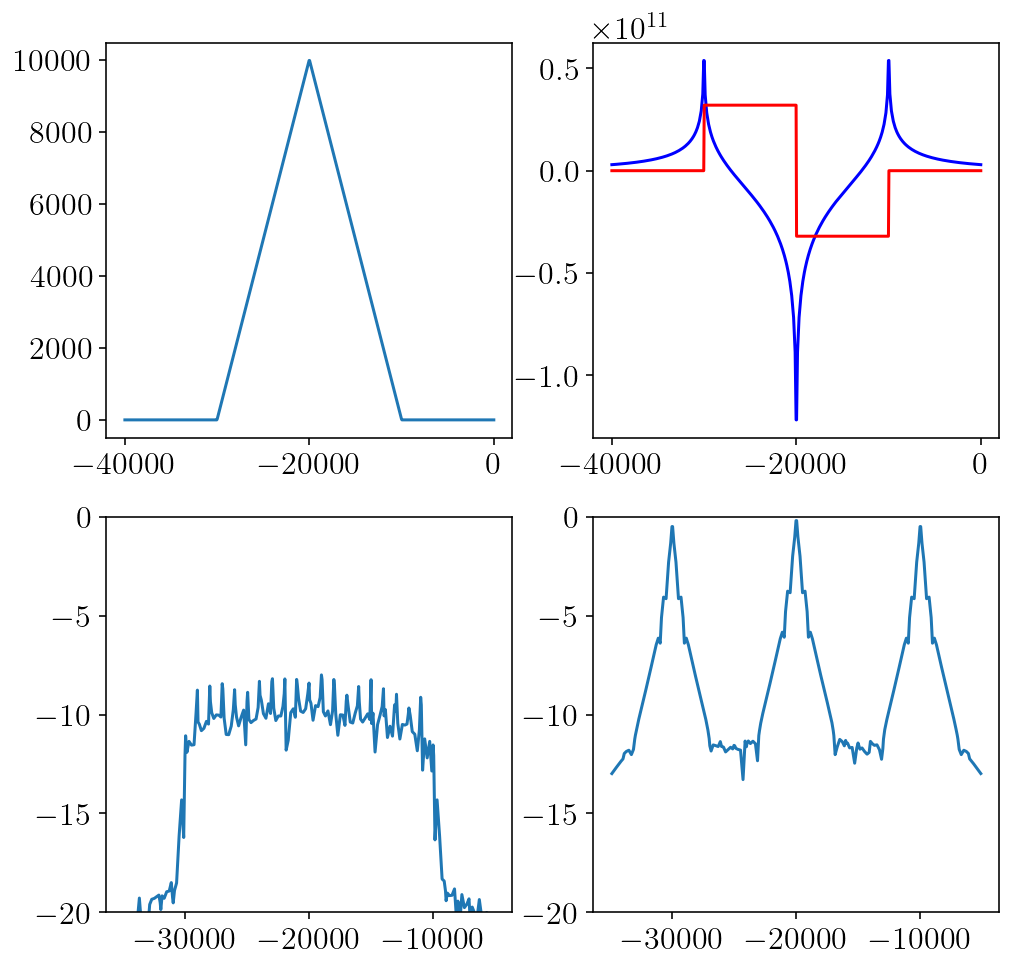

In [18]:
fy = fault.pts[:,1]
v = -np.abs(fy + 20000) + 10000
slip = np.where(v > 0, v, 0)
true_syz = np.where(fy > -30000, np.where(fy < -20000, shear_modulus, np.where(fy < -10000, -shear_modulus, 0)), 0)
safe_stress = tensor_dot(safe_slip_to_stress, slip)
unsafe_stress = tensor_dot(unsafe_slip_to_stress, slip)
plt.figure(figsize=(8,8))
plt.subplot(2,2,1)
plt.plot(fy, slip)
plt.subplot(2,2,2)
plt.plot(fy,safe_stress[:,0],'b-')
plt.plot(fy,true_syz,'r-')
plt.subplot(2,2,3)
plt.plot(fy, np.log10(np.abs((safe_stress[:,1] - true_syz) / shear_modulus)))
plt.ylim([-20,0])
plt.subplot(2,2,4)
plt.plot(fy, np.log10(np.abs((unsafe_stress[:,1] - true_syz) / shear_modulus)))
plt.ylim([-20,0])
plt.show()

In [19]:
import quadpy
S = quadpy.c1.gauss_kronrod(7)
S2 = quadpy.c1.gauss_legendre(7)
S.points, S.weights, S2.weights

(array([-9.91455371e-01, -9.49107912e-01, -8.64864423e-01, -7.41531186e-01,
        -5.86087235e-01, -4.05845151e-01, -2.07784955e-01,  7.77156117e-16,
         2.07784955e-01,  4.05845151e-01,  5.86087235e-01,  7.41531186e-01,
         8.64864423e-01,  9.49107912e-01,  9.91455371e-01]),
 array([0.02293532, 0.06309209, 0.10479001, 0.14065326, 0.16900473,
        0.19035058, 0.20443294, 0.20948214, 0.20443294, 0.19035058,
        0.16900473, 0.14065326, 0.10479001, 0.06309209, 0.02293532]),
 array([0.12948497, 0.27970539, 0.38183005, 0.41795918, 0.38183005,
        0.27970539, 0.12948497]))

In [20]:
(S.weights * (S.points ** 22)).sum() - (2.0 / 23)

-8.187894806610529e-16